In [66]:
from urllib.request import urlopen
from IPython.display import SVG
import matplotlib.pyplot as plt
from rdkit import Chem
from tqdm import tqdm
import pandas as pd
import xlsxwriter
import argparse
import pickle
import numpy as np
import json
import copy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import visualizer as visualizer
import utils as utils
import handle_network as hn
import fragmentation_py as fragmentation_py
import library_downloader as library_downloader
import SiteLocator as modSite
import alignment as alignment
from Compound_n import Compound
from ModificationSiteLocator import ModificationSiteLocator

library ="BERKELEY-LAB"
if not os.path.exists( os.path.join("../data/libraries", library)):
    url = "https://gnps-external.ucsd.edu/gnpslibrary/" + library + ".json"
    location = "../data/libraries/" + library + "/"
    library_downloader.download(url, location, 0.5, 0.1)

with open(os.path.join("../data/libraries", library, "data_dict_filtered.pkl"), "rb") as f:
    data_dict_filtered = pickle.load(f)

# load matches
with open(os.path.join("../data/libraries", library, "matches.pkl"), "rb") as f:
    matches = pickle.load(f)

# load cachedStructures_filtered
with open(os.path.join("../data/libraries", library, "cachedStructures.pkl"), "rb") as f:
    cachedStructures_filtered = pickle.load(f)

In [67]:

def is_good(main, modified):
    molData = data_dict_filtered[main]
    modifiedData = data_dict_filtered[modified]
    molMol = cachedStructures_filtered[main]
    modifiedMol = cachedStructures_filtered[modified]

    if molData["Adduct"] != modifiedData["Adduct"] or molData["Adduct"] != "M+H":
        return -7

    if abs(float(molData["Precursor_MZ"]) - float(modifiedData["Precursor_MZ"])) < 20:
        return -1
    matchedPeaks = alignment.handle_alignment(molData, modifiedData)['matchedPeaks']
    if len(matchedPeaks) < 6:
        return -2
    
    shifted, unshifted = utils.separateShifted(matchedPeaks,  molData["peaks"], modifiedData["peaks"])
    if len(shifted) < 3:
        return -2
    
    if not modifiedMol.HasSubstructMatch(molMol):
        return -3
    
    main_c = Compound(molData, molMol)
    modified_c = Compound(modifiedData, modifiedMol)

    before = copy.deepcopy(main_c.peak_fragments_map)
    helperDirectory = os.path.join("../data/libraries", library, "nf_output/fragmentationtrees/")
    try:
        with open(os.path.join(helperDirectory, main + "_fragmentationtree.json")) as f:
            molSirius = json.load(f)
    except FileNotFoundError:
        return -4
    main_c.apply_sirius(molSirius)
    flag = False
    for i, peak in enumerate(main_c.peaks):
        if (len(main_c.peak_fragments_map[i]) == 1 and len(before[i]) != 1):
            flag = True
            break
    
    if not flag:
        return -5
    
    
    site_locator = ModificationSiteLocator(main_c, modified_c)
    true_modif_loc = utils.calculateModificationSites(modifiedMol, molMol, False)
    print(true_modif_loc)
    score = site_locator.calculate_score(true_modif_loc, "temp")
    if score < 0.95:
        return -6
    print(score)
    
    return 1
    

In [68]:
diff = 0
peak_count = 0
not_sub = 0
while (True):
    print('.', end='')
    try:
        ex = matches[1].pop()
    except:
        break
    m0 = ex[1]
    m1 = ex[0]
    temp = is_good(m0, m1)
    if temp > 0:
        print("temp", temp)
        break
    else:
        if temp == -1:
            diff += 1
        elif temp == -2:
            peak_count += 1
        elif temp == -3:
            not_sub += 1

print (not_sub, peak_count, diff)

molData = data_dict_filtered[m0]
modifiedData = data_dict_filtered[m1]
molMol = cachedStructures_filtered[m0]
modifiedMol = cachedStructures_filtered[m1]

print(molData["Precursor_MZ"], modifiedData["Precursor_MZ"])

............[10]
..................[24]
.[14]
.................[0]
................[9]
.........[11]
.......[20]
........[0]
........[6]
.[14]
....................[0]
............[10]
...[27]
....................[5]
.....................................[25]
.....[5]
.....................[4]
.[6]
........[8]
.....................[0]
.................[6]
...................[11]
...........[0]
..........[20]
.[12]
.[8]
.....[18]
....[3]
...........[6]
......[0]
.............[3]
.......................[5]
............[17]
....[8]
.[18]
..[15]
.................[13]
................[16]
......[9]
..[16]
.[4]
..[14]
[1.]
temp 1
0 20 92
205.097 247.108


In [69]:
# #force m1, m2
# m0 = "CCMSLIB00010122735"
# m1 = "CCMSLIB00010123634"

In [70]:
# m0 = "CCMSLIB00010120498"
# m1 = "CCMSLIB00010125931"

In [71]:
m0 = "CCMSLIB00010103083"
m1 = "CCMSLIB00010103305"

In [72]:
print(m0, m1)
print(hn.generate_usi(m0, library))
print(hn.generate_usi(m1, library))


CCMSLIB00010103083 CCMSLIB00010103305
mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00010103083
mzspec:GNPS:BERKELEY-LAB:accession:CCMSLIB00010103305


True


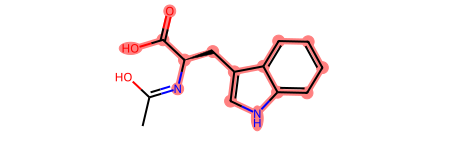

In [73]:
molData = data_dict_filtered[m0]
modifiedData = data_dict_filtered[m1]
molMol = cachedStructures_filtered[m0]
modifiedMol = cachedStructures_filtered[m1]
main_c_before = Compound(molData, molMol, args={"filter_peaks_method":"top_k", "filter_peaks_variable":30})
main_c = Compound(molData, molMol, args={"filter_peaks_method":"top_k", "filter_peaks_variable":30})
main_c_after = Compound(molData, molMol, args={"filter_peaks_method":"top_k", "filter_peaks_variable":30})
helperDirectory = os.path.join("../data/libraries", library, "nf_output/fragmentationtrees/")
try:
    with open(os.path.join(helperDirectory, m0 + "_fragmentationtree.json")) as f:
        molSirius = json.load(f)
except FileNotFoundError:
    print("File not found")
main_c_after.apply_sirius(molSirius)
modified_c = Compound(modifiedData, modifiedMol)
site_locator = ModificationSiteLocator(main_c_after, modified_c)
true_modif_loc = utils.calculateModificationSites(modifiedMol, molMol, False)
print(modifiedMol.HasSubstructMatch(molMol))
modifiedMol.GetSubstructMatch(molMol)
modifiedMol

205.097
247.108
precursuor MZ: 205.097 247.108
205.097 100.0


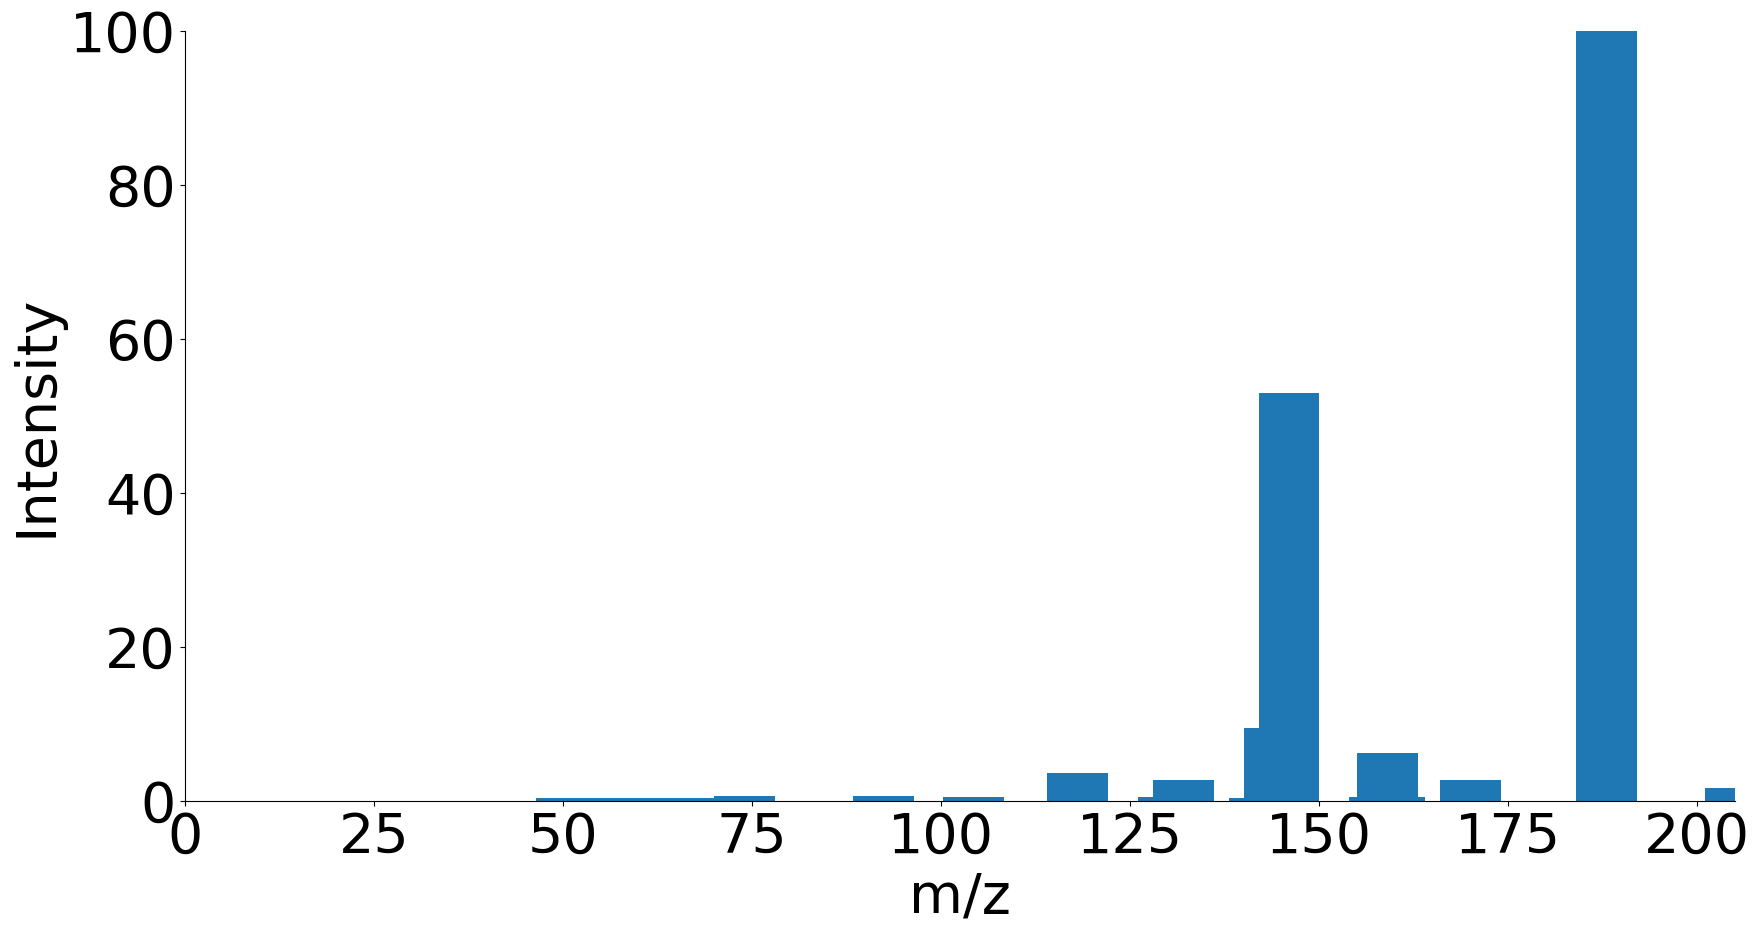

In [114]:
# draw peaks
def draw_peaks(data, name):
    plt.figure(figsize=(20, 10))
    mz = [data[i][0] for i in range(len(data))]
    intensity = [data[i][1] for i in range(len(data))]
    intensity = np.array(intensity)
    intensity = intensity / max(intensity) * 100
    plt.bar(mz, intensity, width=8)
    # remove borders
    plt.xlim(0, max(mz))
    plt.ylim(0, max(intensity))

    #remove black borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.xlabel("m/z", fontsize=40)
    plt.ylabel("Intensity", fontsize=40)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)

    # make plot transparent
    plt.gca().patch.set_alpha(0)

    print(max(mz), max(intensity))
    
    plt.savefig("./images/" + name + ".png", bbox_inches='tight', transparent=True)
    plt.show()

print(data_dict_filtered[m0]["Precursor_MZ"])
print(data_dict_filtered[m1]["Precursor_MZ"])
print("precursuor MZ:", main_c.Precursor_MZ, modified_c.Precursor_MZ)

draw_peaks(main_c.peaks, "mol_spec")

247.108002 100.0


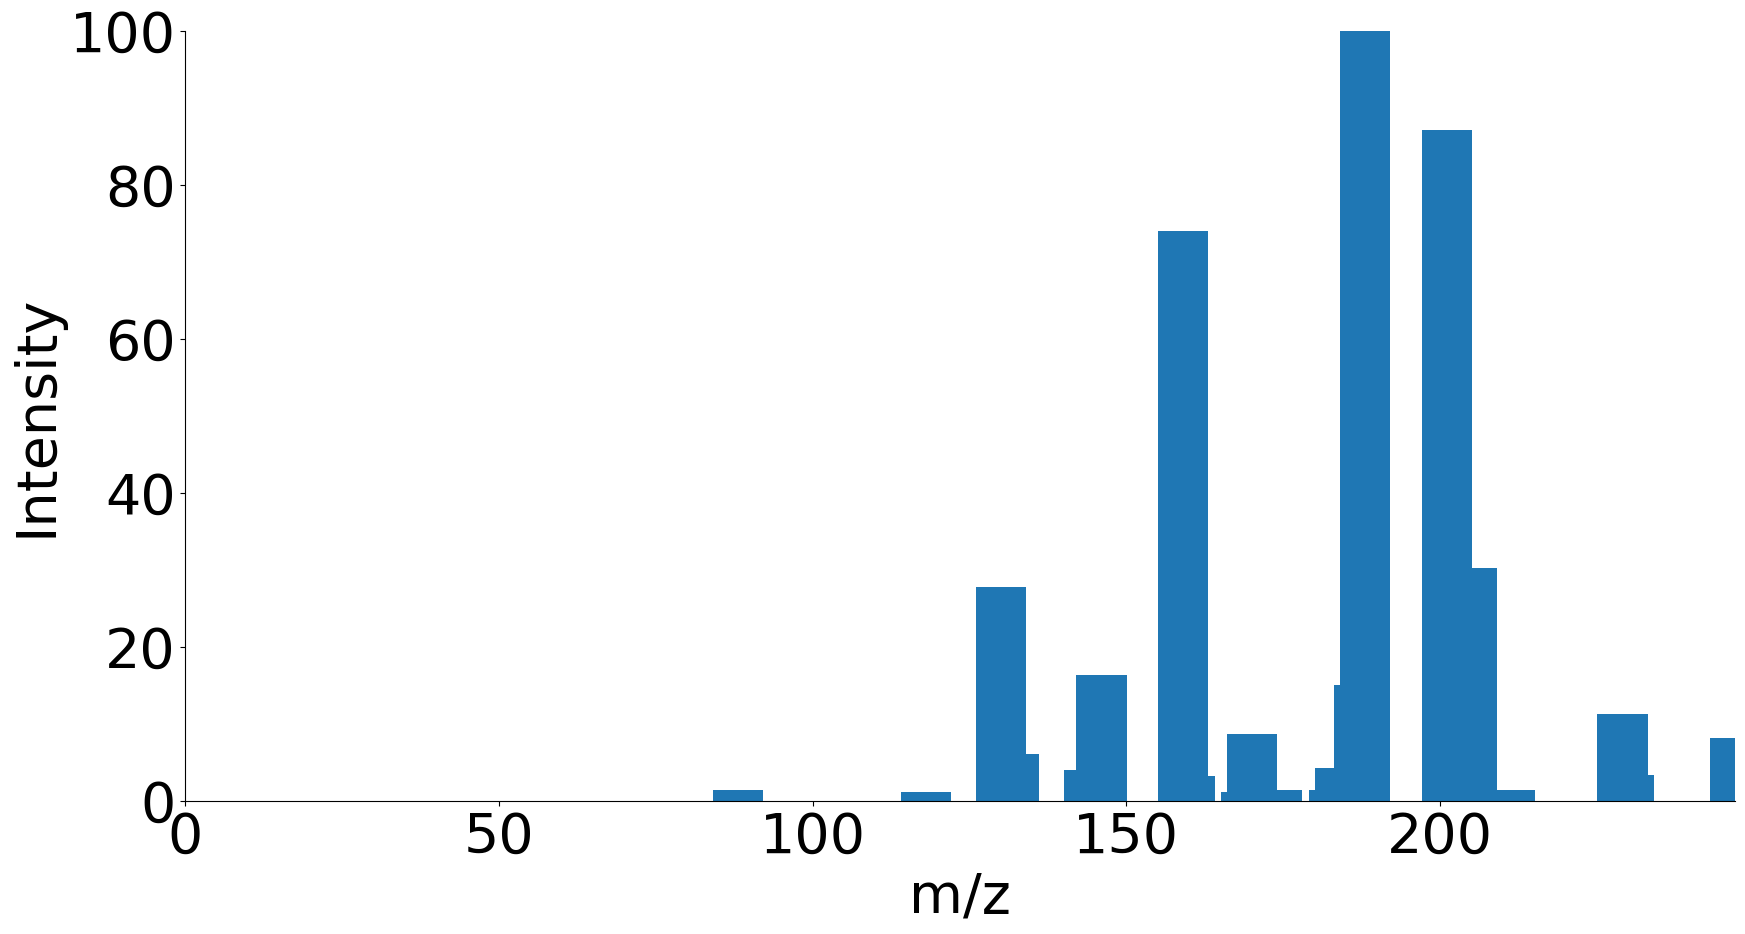

[(88.040001, 0.008869491009425813),
 (118.066002, 0.00702840726765569),
 (130.048996, 0.0079301870395029),
 (130.065002, 0.17385761439665567),
 (132.080994, 0.037562532877518144),
 (144.080994, 0.024712437108047214),
 (146.059998, 0.10192919826076877),
 (159.091995, 0.46206946248801306),
 (160.076004, 0.019850672308760843),
 (169.076996, 0.007191693258292044),
 (170.059998, 0.053972530066592285),
 (174.091995, 0.008301004474852268),
 (183.091995, 0.00910372171478585),
 (184.076004, 0.026955782955201343),
 (187.085999, 0.09408069643552879),
 (188.070007, 0.625000813988638),
 (201.102005, 0.5442697478766213),
 (205.097, 0.18880987586210482),
 (211.087006, 0.00908896197170837),
 (229.095993, 0.0704688227786938),
 (230.080994, 0.02112652881849055),
 (247.108002, 0.050747002689247825)]

In [113]:
draw_peaks(modified_c.peaks, "modified_spec")
modified_c.peaks

In [76]:
import cairosvg
# draw mol png
def draw_mol(mol, name):
    mol = Chem.MolFromSmiles(mol)
    drawer = Chem.Draw.rdMolDraw2D.MolDraw2DSVG(400, 400)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace("svg:", "")
    with open("./images/" + name + ".svg", "w") as f:
        f.write(svg)
    cairosvg.svg2png(url="./images/" + name + ".svg", write_to="./images/" + name + ".png", background_color="transparent")

draw_mol(molData["Smiles"], "molMol")

In [77]:
site_locator.modified_compound.peaks

[(88.040001, 0.008869491009425813),
 (118.066002, 0.00702840726765569),
 (130.048996, 0.0079301870395029),
 (130.065002, 0.17385761439665567),
 (132.080994, 0.037562532877518144),
 (144.080994, 0.024712437108047214),
 (146.059998, 0.10192919826076877),
 (159.091995, 0.46206946248801306),
 (160.076004, 0.019850672308760843),
 (169.076996, 0.007191693258292044),
 (170.059998, 0.053972530066592285),
 (174.091995, 0.008301004474852268),
 (183.091995, 0.00910372171478585),
 (184.076004, 0.026955782955201343),
 (187.085999, 0.09408069643552879),
 (188.070007, 0.625000813988638),
 (201.102005, 0.5442697478766213),
 (205.097, 0.18880987586210482),
 (211.087006, 0.00908896197170837),
 (229.095993, 0.0704688227786938),
 (230.080994, 0.02112652881849055),
 (247.108002, 0.050747002689247825)]

draw allignment

[(88.040001, 0.008869491009425813), (118.066002, 0.00702840726765569), (130.048996, 0.0079301870395029), (130.065002, 0.17385761439665567), (132.080994, 0.037562532877518144), (144.080994, 0.024712437108047214), (146.059998, 0.10192919826076877), (159.091995, 0.46206946248801306), (160.076004, 0.019850672308760843), (169.076996, 0.007191693258292044), (170.059998, 0.053972530066592285), (174.091995, 0.008301004474852268), (183.091995, 0.00910372171478585), (184.076004, 0.026955782955201343), (187.085999, 0.09408069643552879), (188.070007, 0.625000813988638), (201.102005, 0.5442697478766213), (205.097, 0.18880987586210482), (211.087006, 0.00908896197170837), (229.095993, 0.0704688227786938), (230.080994, 0.02112652881849055), (247.108002, 0.050747002689247825)]
debugging [(88.040001, 0.01419116713276321), (118.066002, 0.01124543698239641), (130.048996, 0.012688282738215862), (130.065002, 0.27817182074872665), (132.080994, 0.060099974330915025), (144.080994, 0.03953984787689647), (146.05

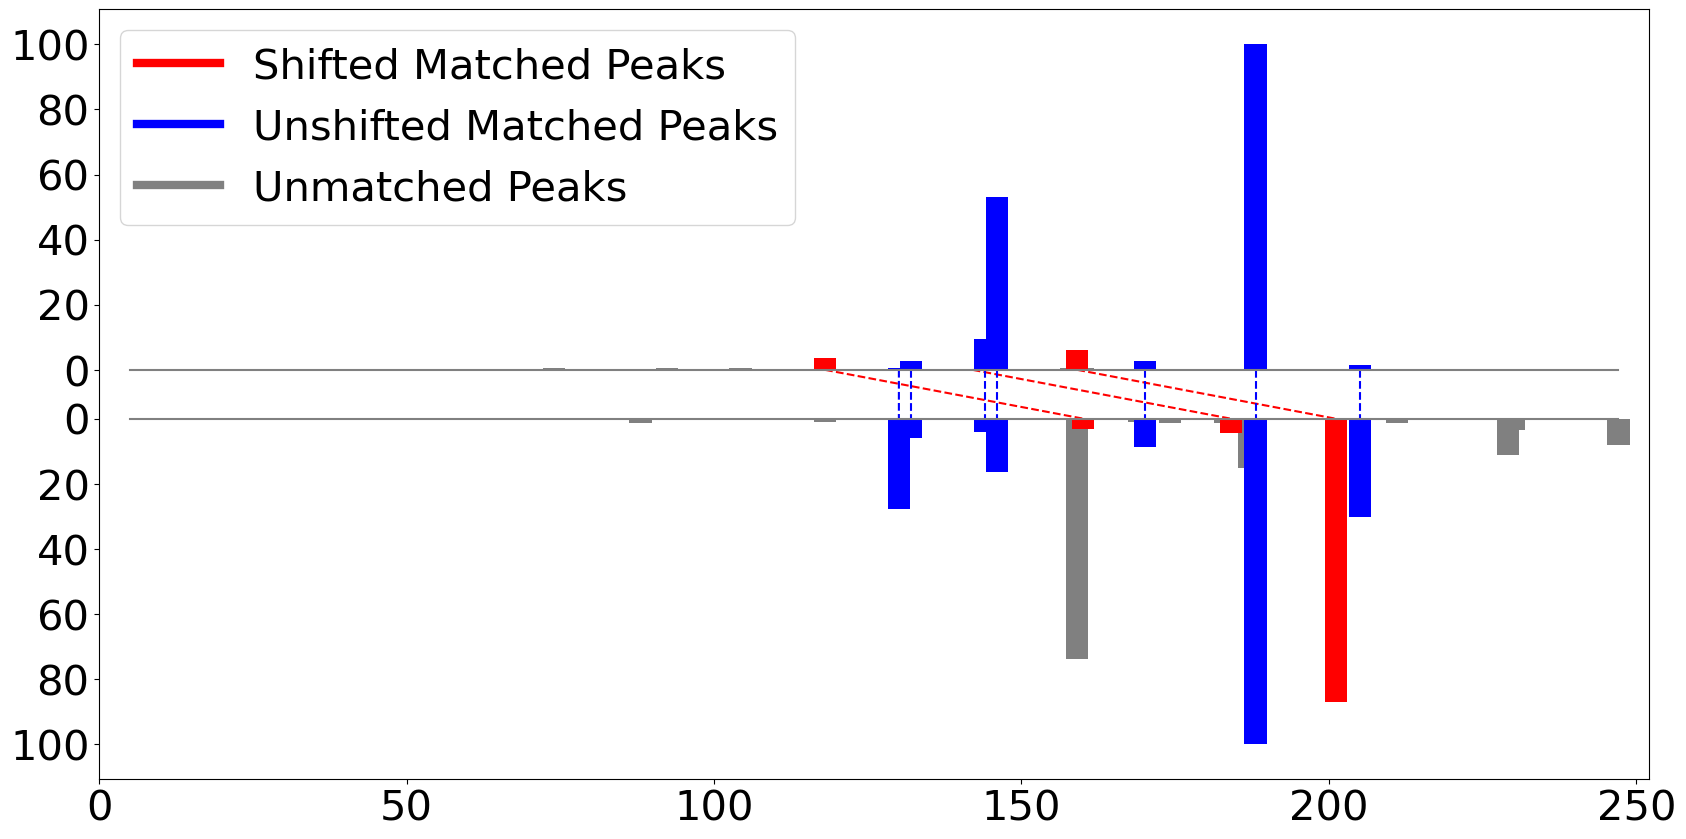

In [112]:
print(modified_c.peaks)
res = visualizer.draw_alignment(site_locator.main_compound.peaks, modified_c.peaks, site_locator.matched_peaks, shift = 0.15, scale=3)
plt.savefig("./images/alignment.png", bbox_inches='tight', transparent=True)

draw hitmap

[0.22222222 0.05555556 0.         0.02777778 0.02777778 0.08333333
 0.02777778 0.05555556 0.08333333 0.08333333 0.05555556 0.02777778
 0.02777778 0.05555556 0.16666667] 0.2222222222222222 1
[1.]


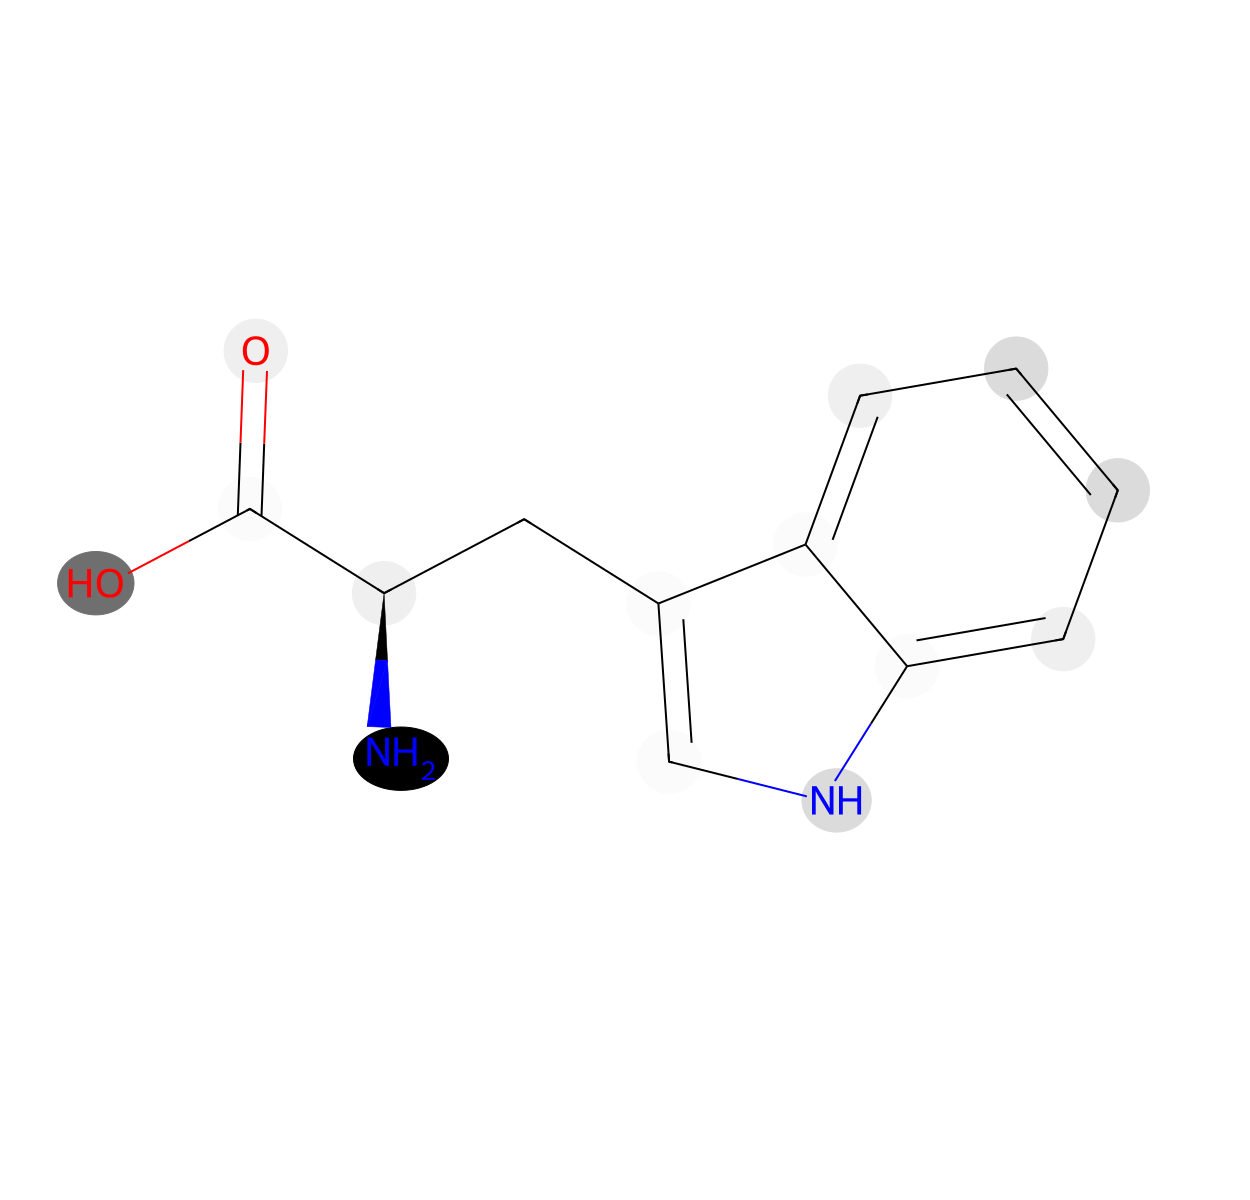

In [115]:
scores = site_locator.generate_probabilities()
print(scores, max(scores), np.count_nonzero(scores == max(scores)))
print(site_locator.calculate_score(true_modif_loc, "temp"))

import rdkit.Chem.Draw as Draw
vals = [x/max(scores) for x in scores]
d2d = Draw.MolDraw2DSVG(1250,1200)
colors = dict()
for i in range(0, molMol.GetNumAtoms()):
    colors[i] = (1-(vals[i]**2), 1-(vals[i]**2), 1-(vals[i]**2))
d2d.DrawMolecule(molMol, highlightAtoms=list(range(molMol.GetNumAtoms())), highlightAtomColors=colors, highlightBonds=[])
d2d.FinishDrawing()
svg_text = d2d.GetDrawingText()
# svg to png
with open("./images/alignment_highlilght.svg", "w") as f:
    f.write(svg_text)
cairosvg.svg2png(url="./images/alignment_highlilght.svg", write_to="./images/alignment_highlilght.png", background_color="transparent")
SVG(svg_text)

Draw modification part

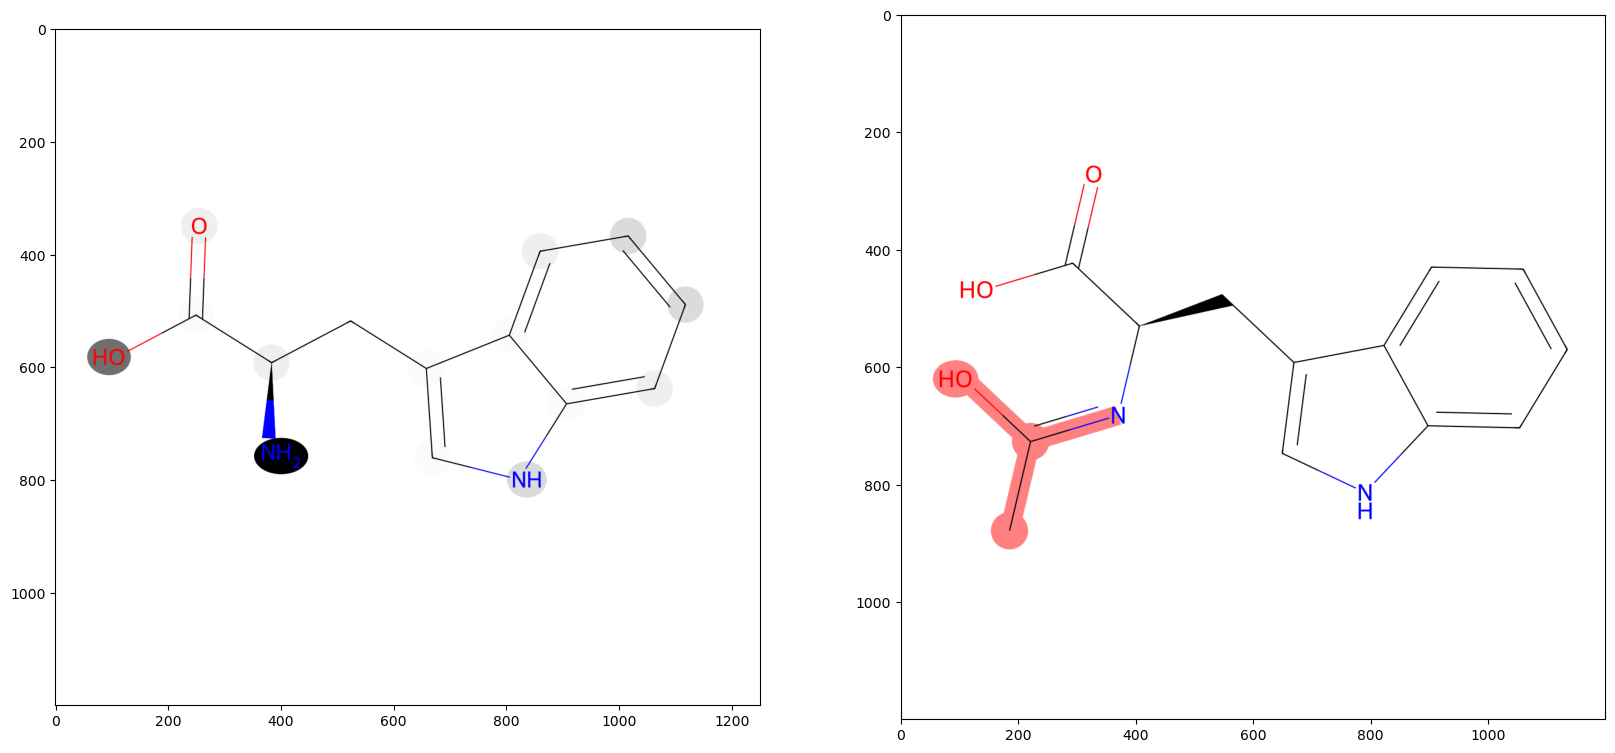

In [116]:
sharedMol = modified_c.structure.GetSubstructMatch(main_c.structure)

highlightAtoms = [i for i in range(modified_c.structure.GetNumAtoms()) if i not in sharedMol]
highlightBonds = []
for bond in modified_c.structure.GetBonds():
    if bond.GetBeginAtomIdx() in highlightAtoms or bond.GetEndAtomIdx() in highlightAtoms:
        highlightBonds.append(bond.GetIdx())

img = Chem.Draw.MolToImage(modified_c.structure, highlightAtoms=highlightAtoms, highlightBonds=highlightBonds, size=(1200, 1200))
img.save("./images/modifiedMol_highlight.png")
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(plt.imread("./images/alignment_highlilght.png"))
ax[1].imshow(plt.imread("./images/modifiedMol_highlight.png"))

Draw all the substructs on a peak

In [110]:
def draw_substructures_for_peak(main_c, selected_peak):
    plt.figure(figsize=(20, 10))
    
    intensity = [x[1] for x in main_c.peaks]
    mz = [x[0] for x in main_c.peaks]
    intensity = np.array(intensity)
    intensity = intensity / max(intensity) * 100

    plt.bar(mz, intensity, width=8)

    # remove borders
    plt.xlim(0, max(mz))
    plt.ylim(0, max(intensity))

    #remove black borders
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # change color of selected peak
    plt.bar(mz[selected_peak], intensity[selected_peak], width=8, color="red")

    # return plot
    plt.xlabel("m/z", fontsize=40)
    plt.ylabel("Intensity", fontsize=40)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)

    # make plot transparent
    plt.gca().patch.set_alpha(0)

    frags = main_c.peak_fragments_map[selected_peak]
    print(frags)
    imgs = []
    texts = []
    for frag in frags:
        highlightedAtoms = main_c.fragments.get_fragment_info(frag, 0)[1]
        highlightBonds = []
        for bond in main_c.structure.GetBonds():
            if bond.GetBeginAtomIdx() in highlightedAtoms or bond.GetEndAtomIdx() in highlightedAtoms:
                highlightBonds.append(bond.GetIdx())
        img = Chem.Draw.MolToImage(main_c.structure, highlightAtoms=highlightedAtoms, highlightBonds=highlightBonds, size=(1200, 1200), highlightColor=(1, 0, 0))
        imgs.append(img)
        texts.append(main_c.fragments.get_fragment_info(frag, 0)[2])

    img_width = 45
    img_height = 40
    spacing = 0.1
    start = max(2, mz[selected_peak] - (len(imgs)/2 * img_width) - (len(imgs)/2 * spacing * img_width))
    start = min(start, 85)
    # show all possible substructures
    plt.text(start, intensity[selected_peak] + img_height/2 +spacing*img_height, "{", fontsize=40, horizontalalignment='center')
    for i in range(len(imgs)):
        start = start + spacing * img_width
        plt.imshow(imgs[i], extent=[start, start + img_width, intensity[selected_peak]+spacing*img_height,spacing*img_height+intensity[selected_peak]+img_height], aspect='auto')
        plt.text(start + img_width/2, intensity[selected_peak] + img_height + spacing*img_height/2, texts[i], fontsize=30, horizontalalignment='center')
        start = start + img_width
        if i != len(imgs) - 1:
            plt.text(start, intensity[selected_peak] + img_height/2 + spacing*img_height, ",", fontsize=40, horizontalalignment='center')


    start = start + spacing * img_width
    plt.axvline(x=mz[selected_peak], ymin=(intensity[selected_peak]/100), ymax=(intensity[selected_peak] + img_height/2-10)/100, color="red", linestyle="--", linewidth=5)
    plt.text(start, intensity[selected_peak] + img_height/2 +spacing*img_height, "}", fontsize=40, horizontalalignment='center')

    # draw vertical line
    print("ymax", intensity[selected_peak] + img_height/2,mz[selected_peak], intensity[selected_peak])
    # draw line on top of everything
    
    

    return plt





In [82]:

before = copy.deepcopy(main_c.peak_fragments_map)
flag = False
selected_peak = -1
for i, peak in enumerate(main_c.peaks):
    if (len(main_c_after.peak_fragments_map[i]) == 1 and len(before[i]) != 1):
        print("here", i, before[i], main_c_after.peak_fragments_map[i])
        flag = True
        selected_peak = i
        break

print(flag)

here 9 {4088, 14462} {4088}
True


{4088, 14462}
ymax 23.615797429658393 118.065002 3.6157974296583926


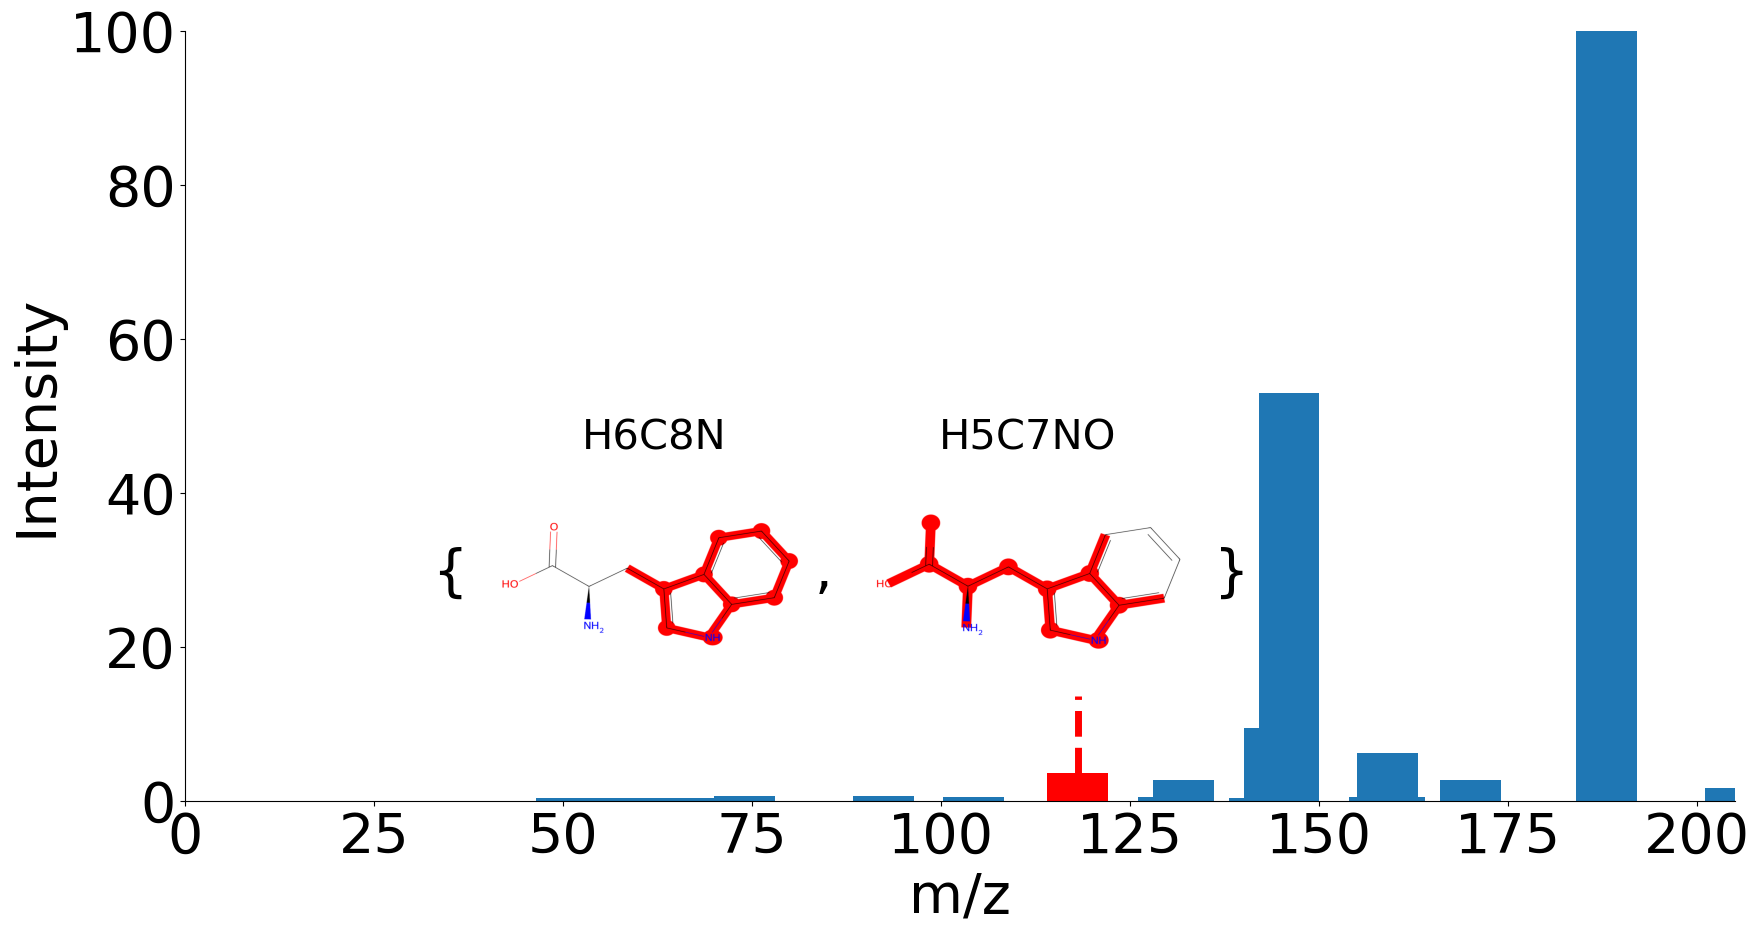

In [107]:
pl = draw_substructures_for_peak(main_c_before, selected_peak)
pl.savefig("./images/peak_before_sirius.png", bbox_inches='tight', transparent=True)

{4088}
ymax 23.615797429658393 118.065002 3.6157974296583926


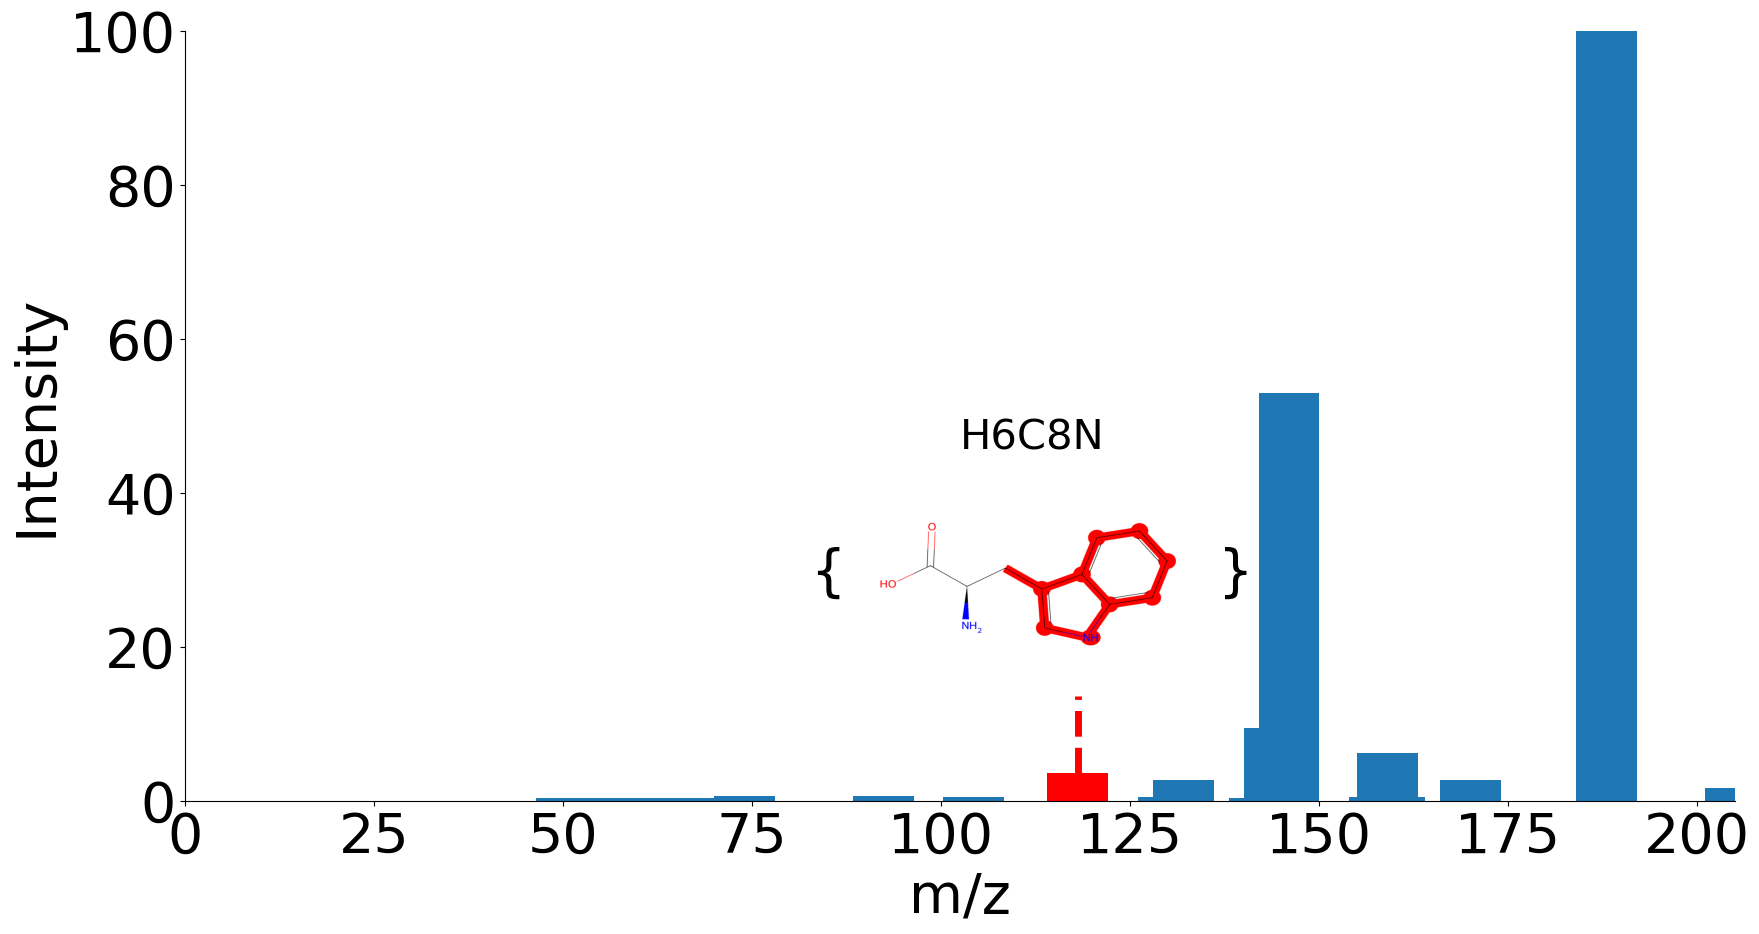

In [111]:
draw_substructures_for_peak(main_c_after, selected_peak)
pl.savefig("./images/peak_after_sirius.png", bbox_inches='tight', transparent=True)